In [1]:
import sys
sys.path.append('/Users/user/miniconda3/lib/python3.8/site-packages')

In [2]:
import os
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from nltk import word_tokenize
from collections import Counter
from torch.autograd import Variable

In [3]:
# 初始化参数设置
BATCH_SIZE = 64  # 每批次训练数据数量
EPOCHS = 20  # 训练轮数
LAYERS = 6  # transformer中堆叠的encoder和decoder block层数
H_NUM = 8  # multihead attention hidden个数
D_MODEL = 256  # embedding维数
D_FF = 1024  # feed forward第一个全连接层维数
DROPOUT = 0.1  # dropout比例
MAX_LENGTH = 60  # 最大句子长度

TRAIN_FILE = 'nmt/en-cn/train.txt'  # 训练集数据文件
DEV_FILE = "nmt/en-cn/dev.txt"  # 验证(开发)集数据文件
SAVE_FILE = 'save/model.pt'  # 模型保存路径
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 准备数据

In [87]:
class PrepareData:
    def __init__(self, train_file, dev_file):
        # 读取数据 并分词
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn = self.load_data(dev_file)
        
        # 构建单词表,记录语料库中每个单词的下标，和反向字典
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)
        
        # id化
        self.train_en, self.train_cn = self.wordToID(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn = self.wordToID(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)

    def load_data(self, path):
        """
        读取翻译前(英文)和翻译后(中文)的数据文件
        每条数据都进行分词，然后构建成包含起始符(BOS)和终止符(EOS)的单词(中文为字符)列表
        形式如：en = [['BOS', 'i', 'love', 'you', 'EOS'], ['BOS', 'me', 'too', 'EOS'], ...]
                cn = [['BOS', '我', '爱', '你', 'EOS'], ['BOS', '我', '也', '是', 'EOS'], ...]
        """
        en = []
        cn = []
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                # 分开中英文, ['Anyone can do that.', '任何人都可以做到。']
                line = line.strip().split('\t')
                # 将句子分词，英文全转换为小写
                en.append(["BOS"] + word_tokenize(line[0].lower()) + ["EOS"])
                cn.append(["BOS"] + [w for w in line[1]] + ["EOS"])
        return en, cn
    
    def build_dict(self, sentences, max_words=50000):
        """
        传入load_data构造的分词后的列表数据
        构建词典(key为单词，value为id值)
        """
        # 对数据中所有单词进行计数
        word_count = Counter()

        for sentence in sentences:
            for s in sentence:
                word_count[s] += 1
        # 只保留最高频的前max_words数的单词构建词典
        # 并添加上UNK和PAD两个单词，对应id已经初始化设置过
        # [('BOS',14533),....]
        # 生成出现次数大于max_words的所有词的语料库
        ls = word_count.most_common(max_words)
        # 统计词典的总词数,为UNK和padding的0预留
        total_words = len(ls) + 2
        # 记录每个语料库中的词的下标，从2开始，0，1留给unknow和padding
        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}
        word_dict['UNK'] = 0
        word_dict['PAD'] = 1
        # 再构建一个反向的词典，供id转单词使用
        index_dict = {v: k for k, v in word_dict.items()}

        return word_dict, total_words, index_dict
    
    def wordToID(self, en, cn, en_dict, cn_dict, sort=True):
        """
        该方法可以将翻译前(英文)数据和翻译后(中文)数据的单词列表表示的数据
        均转为id列表表示的数据
        如果sort参数设置为True，则会以翻译前(英文)的句子(单词数)长度排序
        以便后续分batch做padding时，同批次各句子需要padding的长度相近减少padding量
        """
        # 计算英文数据条数
        length = len(en)
        # 将翻译前(英文)数据和翻译后(中文)数据都转换为id表示的形式,[[2,324,23,21],[21,22,3,4],...]
        # 跳过没有出现在语料库里的词
        out_en_ids = [[en_dict[w] for w in sent if w in en_dict] for sent in en]
        out_cn_ids = [[cn_dict[w] for w in sent if w in cn_dict] for sent in cn]
        
        # 记录ID化后的英语，中文句子的长度，准备按长度排序，减少padding量
        len_en_ids=[len(sent) for sent in out_en_ids]
        len_cn_ids=[len(sent) for sent in out_cn_ids]
        
        # 按长度排序的句子下标
        sorted_len_en=np.argsort(len_en_ids)

        # 把中文和英文按照同样的顺序排序
        if sort:
            # 以英文句子长度排序的(句子下标)顺序为基准
            # 对翻译前(英文)数据和翻译后(中文)数据都按此基准进行排序
            out_en_ids = [out_en_ids[i] for i in sorted_len_en]
            out_cn_ids = [out_cn_ids[i] for i in sorted_len_en]
            
        return out_en_ids, out_cn_ids

### 部分句子向量和平行语料库展示

In [88]:
Data=PrepareData(TRAIN_FILE,DEV_FILE)
Data.load_data(TRAIN_FILE)
print(Data.train_en[0])
print(Data.train_cn[0])

[2, 1318, 126, 3]
[2, 119, 1368, 221, 3]


In [89]:
print(Data.en_index_dict[8])
print(Data.cn_index_dict[8])
Data.en_total_words

you
你


5493

## 将句子补全成一样长度

In [29]:
def seq_padding(X, padding=0):
    """
    X: 这个batch所有句子
    对一个batch批次(以单词id表示)的数据进行padding填充对齐长度
    """
    # 计算该批次数据各条数据句子长度
    L = [len(x) for x in X]
    # 获取该批次数据最大句子长度
    ML = max(L)
    # 对X中各条数据x进行遍历，如果长度短于该批次数据最大长度ML，则以padding id填充缺失长度ML-len(x)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])

In [101]:
Data.train_en=seq_padding(Data.train_en)
Data.train_cn=seq_padding(Data.train_cn)
Data.train_en

array([[   2, 1318,  126, ...,    0,    0,    0],
       [   2, 1882,    4, ...,    0,    0,    0],
       [   2, 2045,  126, ...,    0,    0,    0],
       ...,
       [   2,   88,    8, ...,    0,    0,    0],
       [   2,  430,   95, ...,    0,    0,    0],
       [   2,   88,    9, ...,  458,    4,    3]])

## Embeddings

我们在两个embedding层和pre-softmax线性变换层之间共享相同的权重矩阵。这么做可以节省参数，也是一种正则化方式。  
在其中的embedding层，我们会将这些权重乘以 $\sqrt{d_{model}}$ 。

In [102]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        # Embedding层
        self.lut = nn.Embedding(vocab, d_model)
        # Embedding维数
        self.d_model = d_model

    def forward(self, x):
        # 返回x对应的embedding矩阵（需要乘以math.sqrt(d_model)）
        return self.lut(x) * math.sqrt(self.d_model)

## Transformer model

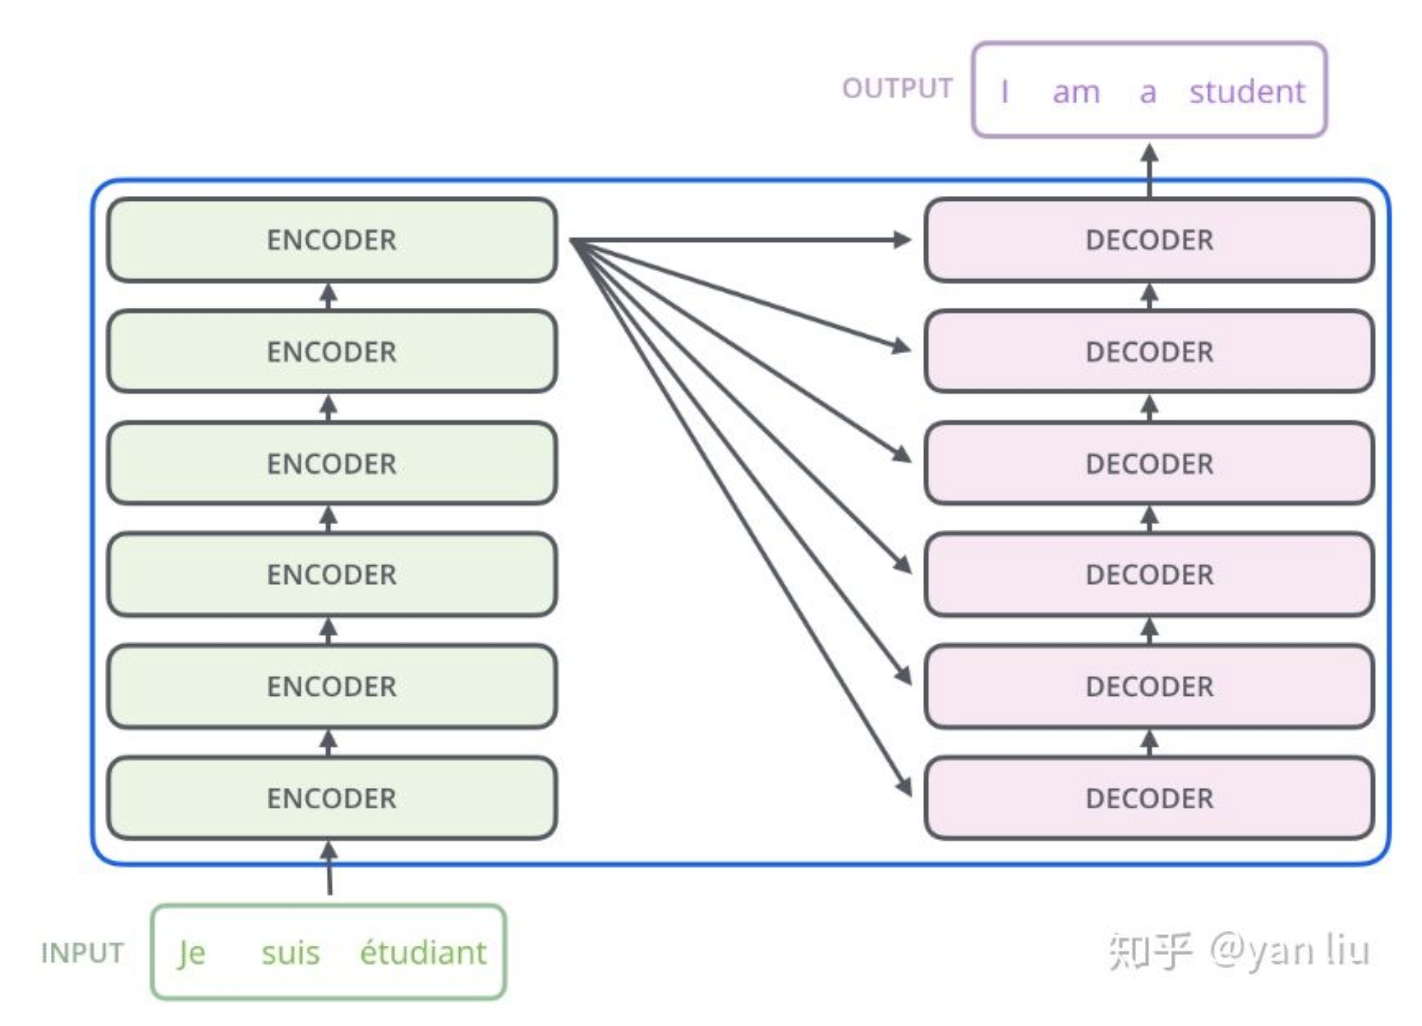

## 编码器部分（Encoder）
  
**编码器（$Encoder$）**部分, 即把**自然语言序列映射为隐藏层的数学表达的过程**。

Encoder由N=6个相同的layer组成，layer指的就是上图左侧的6个单元。

每个Layer由两个sub-layer组成，分别是multi-head self-attention mechanism和fully connected feed-forward network。

其中每个sub-layer都加了residual connection和normalisation，因此可以将sub-layer的输出表示为：

$sub_layer_output=LayerNorm(x+(SubLayer(x)))$

### positional encoding（即位置嵌入或位置编码）

**将词序信息加入到模型中**

为语料库里的每一个下标生成独一无二的向量

在论文 **attention is all you need**（ https://arxiv.org/pdf/1706.03762.pdf ）中使用了$sine$和$cosine$函数的线性变换来提供给模型位置信息：   
  
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \quad \quad PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})\tag{eq.1}$$  


上式中$pos$指的是句中字的位置，在self.en_word_dict和self.cn_word_dict中存储，取值范围是$[0, \ max \ sequence \ length)$，$i$指的是词向量的维度

我们会得到一组参数不同的sin、cos函数，使用它们相加作为最终向量，保证每个位置的最终向量都不一样

**位置编码的需求:**

1. 需要体现同一个单词在不同位置的区别；

2. 需要体现一定的先后次序关系，并且在一定范围内的编码差异不应该依赖于文本长度，具有一定不变性。我们又需要值域落入一定数值区间内的编码，又需要保证编码与文本长度无关


In [103]:
# 导入依赖库
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # 初始化一个size为 max_len(设定的最大长度)×embedding维度 的全零矩阵
        # 来存放所有小于这个长度位置对应的porisional embedding
        pe = torch.zeros(max_len, d_model, device=DEVICE)
        """
        5000 * 20
        tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
        """
        print(len(pe))
        # 生成一个位置下标的tensor矩阵(每一行都是一个位置下标) d_mo
        position = torch.arange(0., max_len, device=DEVICE).unsqueeze(1)
        # 这里幂运算太多，我们使用exp和log来转换实现公式中pos下面要除以的分母（由于是分母，要注意带负号）
        div_term = torch.exp(torch.arange(0., d_model, 2, device=DEVICE) * -(math.log(10000.0) / d_model))
        # 得到各个位置在各embedding维度上的位置纹理值，存放到pe矩阵中
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 加1个维度，使得pe维度变为：1×max_len×embedding维度
        # (方便后续与一个batch的句子所有词的embedding批量相加)
        pe = pe.unsqueeze(0) 
        # 将pe矩阵以持久的buffer状态存下(不会作为要训练的参数)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # 将一个batch的句子所有词的embedding与已构建好的positional embeding相加
        # (这里按照该批次数据的最大句子长度来取对应需要的那些positional embedding值)
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

### 不同周期的三角函数图像

In [106]:
# plt.figure(figsize=(15, 5))
# 给每个句子生成位置编码
pe = PositionalEncoding(len(Data.train_en[0]), 0,len(Data.train_en))
# y = pe.forward(Variable(torch.zeros(1, 100, 20)))

y = pe.forward(Variable(torch.from_numpy(Data.train_en)))

# plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
# plt.legend(["dim %d"%p for p in [4,5,6,7]])

14533


RuntimeError: The size of tensor a (14533) must match the size of tensor b (38) at non-singleton dimension 1

In [97]:
y[0]

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  3.8767e-01,  ...,  1.0000e+00,
          2.5119e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  7.1471e-01,  ...,  1.0000e+00,
          5.0238e-04,  1.0000e+00],
        ...,
        [ 3.7961e-01, -9.2515e-01,  7.9395e-01,  ...,  9.9813e-01,
          2.4363e-02,  9.9970e-01],
        [-5.7338e-01, -8.1929e-01,  9.6756e-01,  ...,  9.9809e-01,
          2.4614e-02,  9.9970e-01],
        [-9.9921e-01,  3.9821e-02,  9.8984e-01,  ...,  9.9805e-01,
          2.4865e-02,  9.9969e-01]])

### 单层Encoder结构
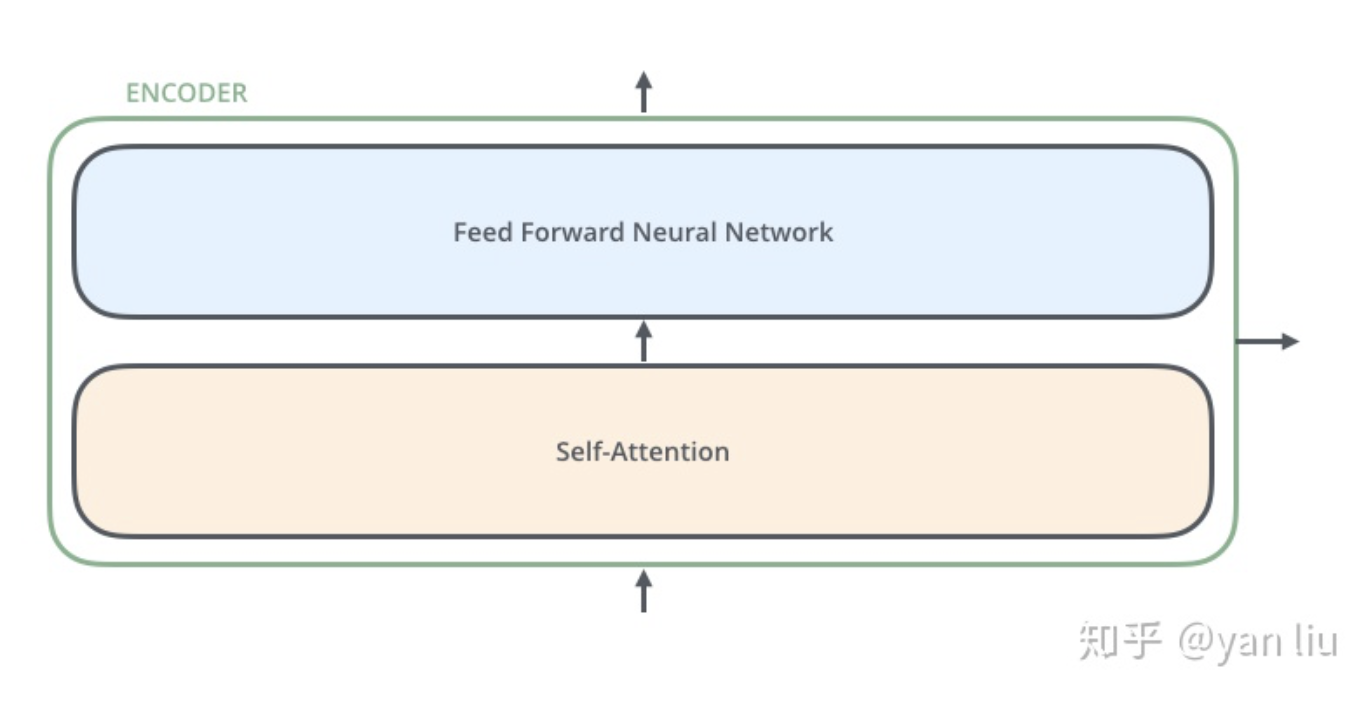

在Transformer的encoder中，数据首先会经过一个叫做‘self-attention’的模块得到一个加权之后的特征向量Z

这个Z便是论文公式1中的$Attension(Q,K,V)$

$Attension(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V=Z$

### Multi-head self-attention

Attention:

$attension_output = Attension(Q,K,V)$

multi-head attention则是通过h个不同的线性变换对Q，K，V进行投影，最后将不同的attention结果拼接起来:

$head_i=Attension(QW_i^Q,KW_i^k,VW_i^V)$

$MultiHead(Q,K,V)=Concat(head_1,head_2,...,head_h)W^o$